In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/Research/Specific Topics/Interpretability of Machine Learning Models in Medical Image Analysis A Study Using the RSNA Pneumonia Dataset/Codes/FSL_WITH_ATTENTION_Model/RSNA_Attention_Resnet50_FSL.keras')

In [3]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess an image
img_path = '/content/drive/MyDrive/Research/Specific Topics/Interpretability of Machine Learning Models in Medical Image Analysis A Study Using the RSNA Pneumonia Dataset/Dataset/Data/pneumonia/000fe35a-2649-43d4-b027-e67796d412e0.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array/255.0, axis=0)  # Normalize to [0,1]

In [7]:
def make_gradcam_plusplus_model():
    conv_layer = model.get_layer('multiply')  # Last conv layer after SE block
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[conv_layer.output, model.output]
    )
    return grad_model
import cv2
def generate_heatmap(img_array):
    grad_model = make_gradcam_plusplus_model()
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        output = predictions[:, pred_index]

    grads = tape.gradient(output, conv_outputs)
    alpha = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    weights = tf.reduce_sum(conv_outputs * alpha, axis=(1, 2), keepdims=True)
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)[0]

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return cv2.resize(heatmap, (150, 150))

In [8]:
!pip install lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

def lime_explanation(img_array):
    def batch_predict(images):
        return model.predict(images)

    explanation = explainer.explain_instance(
        img_array[0],
        batch_predict,
        top_labels=1,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5
    )
    return mask

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━

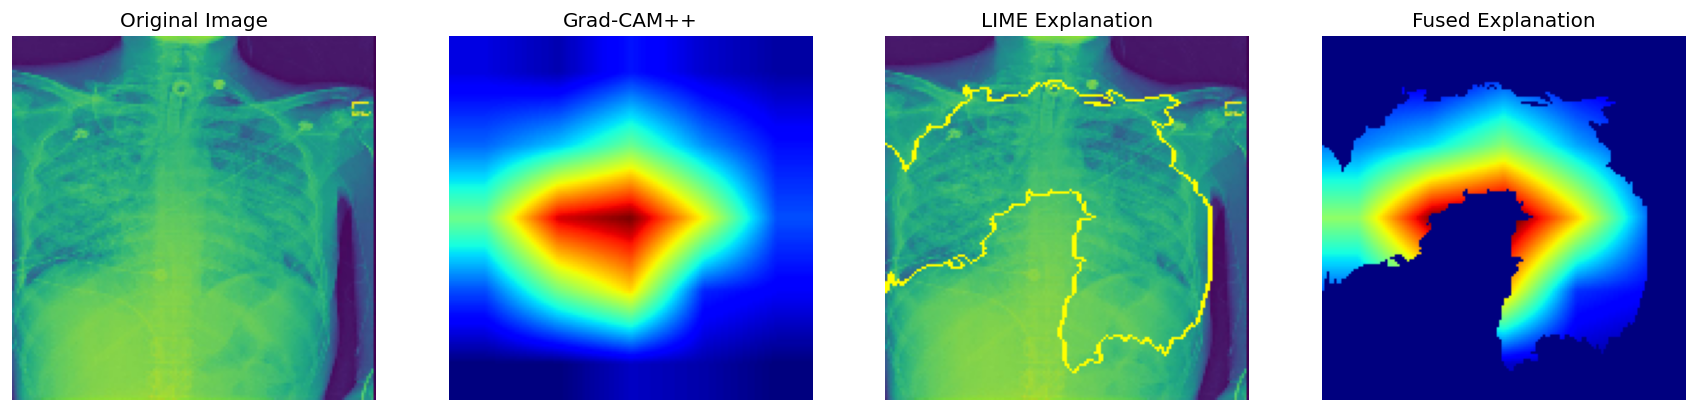

In [11]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Generate explanations
heatmap = generate_heatmap(img_array)
lime_mask = lime_explanation(img_array)

# Fuse masks
combined = (heatmap * lime_mask)  # Element-wise multiplication

# Create figure with higher DPI for better quality
plt.figure(figsize=(18, 6), dpi=120)

# Plot settings
plt.subplot(1, 4, 1)
plt.imshow(img_array[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('Grad-CAM++')

plt.subplot(1, 4, 3)
plt.imshow(mark_boundaries(img_array[0], lime_mask))
plt.axis('off')
plt.title('LIME Explanation')

plt.subplot(1, 4, 4)
plt.imshow(combined, cmap='jet')
plt.axis('off')
plt.title('Fused Explanation')

# Save as SVG
plt.savefig('/content/drive/MyDrive/combined_explanation.svg',
            format='svg', bbox_inches='tight')
plt.show()